In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import time

# Import the graph

In [2]:
graph = nx.read_graphml("LesMiserablesGraph.graphml")

In [3]:
print(nx.info(graph))

Name: 
Type: Graph
Number of nodes: 77
Number of edges: 254
Average degree:   6.5974


# Or create toy graphs

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
import matplotlib.pyplot as plt

In [6]:
def cliques(nb_cliques, clique_size, nb_links_btw_cliques=None):
    graph = nx.caveman_graph(nb_cliques, clique_size)
    cliques_list = [[i for i in range(a * clique_size, (a + 1) *  clique_size)] for a in range(nb_cliques)]
    for i in range(len(cliques_list) - 1):
        graph.add_edge(cliques_list[i][0], cliques_list[i + 1][0])
    if cliques_list[-1][0] not in list(nx.all_neighbors(graph, cliques_list[0][0])):
        graph.add_edge(cliques_list[-1][0], cliques_list[0][0])

    return graph

toy_graph = cliques(4, 10, None)

In [7]:
nx.write_graphml(toy_graph, "toy.graphml")

In [7]:
print(nx.info(toy_graph))

Name: 
Type: Graph
Number of nodes: 40
Number of edges: 184
Average degree:   9.2000


# Create sequences of random walks for our RNN

In [8]:
def random_walk(graph, p_stop=0.1, choose_stop = False, max_length=30):
    nodes = list(graph.nodes)
    edges = np.array(list(graph.edges))
    start_node = np.random.choice(nodes, 1)[0]
    walk_sequence = list()
    current_node = start_node
    max_length = np.random.randint(max_length / 2, max_length * 2)
    i = 0
    while True:
        #print(graph.node[current_node]["label"])
        walk_sequence.append(current_node)
        if choose_stop:
            if np.random.random() < p_stop:
                return walk_sequence
        
        neighbors = np.unique(np.concatenate((edges[edges[:, 0] == current_node][:, 1], edges[edges[:, 1] == current_node][:, 0])))
        current_node = np.random.choice(neighbors, 1)[0]
        i+=1
        if not choose_stop and i > max_length:
            break
    return walk_sequence
        
       
    
#random_walk(toy_graph);

In [9]:
# index (nb_nodes) --> start   index(nb_nodes + 1) --> end

def walk2input(walk_sequence, graph):
    nb_nodes = len(list(graph.nodes))
    walk_vec = torch.zeros(len(walk_sequence) + 1, 1, nb_nodes + 2)
    for i, node in enumerate(walk_sequence):
        walk_vec[i + 1][0][int(node)] = 1
    walk_vec[0][0][-2] = 1
    
    return Variable(walk_vec).float()

def walk2target(walk_sequence, graph):
    nb_nodes = len(list(graph.nodes))
    target_list = map(int, walk_sequence)
    target_list.append(nb_nodes + 1)
    return Variable(torch.LongTensor(target_list))

def train_vecs(graph):
    walk_sequence = random_walk(graph)
    return walk2input(walk_sequence, graph), walk2target(walk_sequence, graph)
    
walk_sequence = random_walk(toy_graph)
#print(walk_sequence)
#print(walk2input(walk_sequence, graph))
#print(walk2target(walk_sequence, graph))
#train_vecs(toy_graph)

In [10]:
def neighbors(node, graph):
    edges = np.array(list(graph.edges))
    return np.unique(np.concatenate((edges[edges[:, 0] == node][:, 1], edges[edges[:, 1] == node][:, 0])))

# Put these sequences in a RNN

In [11]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        print(input_size, hidden_size)
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)
        self.lin = nn.Linear(hidden_size, output_size)
        #self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        #self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        #hidden = self.i2h(input_combined)
        #output = self.i2o(input_combined)
        #output_combined = torch.cat((hidden, output), 1)
        output, hidden = self.lstm(input.view(len(input), 1, -1), hidden)
        output = F.dropout(self.lin(output.view(1, -1)), 0.1,  training = self.training)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (Variable(torch.zeros(1, 1, self.hidden_size)),
                Variable(torch.zeros(1, 1, self.hidden_size)))

In [12]:
n_nodes = len(list(graph.nodes))
print(n_nodes)
hidden_size = 100
rnn = RNN(n_nodes + 2, hidden_size, n_nodes + 2)


77
(79, 100)


## Train the model

In [13]:
from training_func import training_iters
import functools

0m 12s (100 0%) 3.9719
0m 24s (200 1%) 3.6920
0m 36s (300 2%) 3.4587
0m 46s (400 3%) 3.3386
0m 56s (500 4%) 3.2042
1m 4s (600 5%) 3.1226
1m 11s (700 5%) 3.0854
1m 19s (800 6%) 3.0532
1m 27s (900 7%) 2.9451
1m 40s (1000 8%) 2.8559
1m 48s (1100 9%) 2.9000
1m 57s (1200 10%) 2.8563
2m 10s (1300 10%) 2.8568
2m 22s (1400 11%) 2.8043
2m 31s (1500 12%) 2.8065
2m 40s (1600 13%) 2.7566
2m 49s (1700 14%) 2.7810
2m 58s (1800 15%) 2.6910
3m 7s (1900 15%) 2.7073
3m 19s (2000 16%) 2.7217
3m 26s (2100 17%) 2.7026
3m 35s (2200 18%) 2.7264
3m 43s (2300 19%) 2.7420
3m 53s (2400 20%) 2.6476
4m 2s (2500 20%) 2.7084
4m 10s (2600 21%) 2.6735
4m 21s (2700 22%) 2.6670
4m 30s (2800 23%) 2.6906
4m 41s (2900 24%) 2.6246
5m 15s (3000 25%) 2.6995
5m 23s (3100 25%) 2.5880
5m 31s (3200 26%) 2.6695
5m 41s (3300 27%) 2.6313


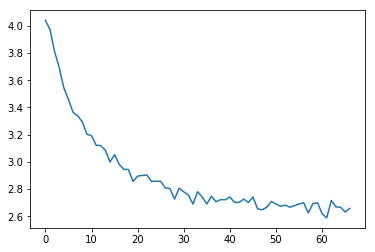

In [18]:
rnn.train()
n_iters = 12000
criterion = nn.NLLLoss()
all_losses = training_iters(n_iters, rnn, functools.partial(train_vecs, graph=graph), criterion, optimizer_name="Adadelta")

# Test the RNN walk generation

In [19]:
rnn.eval()

RNN (
  (lstm): LSTM(79, 100)
  (lin): Linear (100 -> 79)
  (softmax): LogSoftmax ()
)

In [21]:


def sample(graph, rnn, start=None, choose_ending=True, max_length=20,):
    rnn.eval()
    start_input = walk2input(start, graph)
    #print(input.data.size())
    #print(graph.node[start]["label"])
    hidden = rnn.initHidden()
    if len(start_input) > 1:
        for i in range(len(start_input) - 1):
            output, hidden = rnn(start_input[i], hidden)
    
    output_walk = start
    input = start_input
    
    for i in range(max_length):
        output, hidden = rnn(input[-1], hidden)
        topv, topi = output.data.topk(1)
        #print(topi, topv)
        topi = topi[0][0]
        #print(topi)
        if topi == n_nodes + 1:
            if choose_ending:
                return output_walk
            else:
                topi = output.data.topk(2)[1][0][1]
        if type(start[0])== int:
            node = topi
        else:
            node = str(topi)
        #print(graph.node[node]['label'])
        output_walk.append(node)
        input = walk2input([node], graph)
    return output_walk

# Get multiple samples from one category and multiple starting letters
def samples():
    print(sample())
    
sample(graph, rnn,  [0, 1, 0, 2], choose_ending = False)

[0, 1, 0, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2]

## Metrics

In [30]:
def degree(node, graph):
    edges = np.array(list(graph.edges))
    degree = len(np.unique(np.concatenate((edges[edges[:, 0] == node][:, 1], edges[edges[:, 1] == node][:, 0]))))
    return degree

print(degree("2", graph))

3


In [22]:
def nb_correct_walks(rnn, graph):
    edges = list(graph.edges)
    edges_array = np.array(edges)

    nb_walks = 0
    walk_length_sum = 0
    wrong = 0
    for start_node in list(graph.nodes):
        neighbors = list(nx.all_neighbors(graph, start_node))
        for k in range(10):
            second_node = np.random.choice(neighbors, 1)[0]
            walk_sequence = sample(graph, rnn, [start_node, second_node], False)
            walk_length_sum += len(walk_sequence)
            nb_walks += 1


            for i in range(len(walk_sequence) - 1):
                if (walk_sequence[i], walk_sequence[i + 1]) not in edges and (walk_sequence[i + 1], walk_sequence[i]) not in edges:
                    wrong += 1
                    break
    print("{} correct walks on {} walks --> Accuracy : {} /n Average walk length : {}".format((nb_walks - wrong), nb_walks, ((nb_walks - wrong)) / float(nb_walks), walk_length_sum / float(nb_walks)))
    return ((nb_walks - wrong) / float(nb_walks))
nb_correct_walks(rnn, graph)

770 correct walks on 770 walks --> Accuracy : 1.0 /n Average walk length : 22.0


1.0

## How does the score depends on the RNN memory ?

In [32]:
def score_memory(graph, hidden_size_range):
    nb_nodes = len(list(graph.nodes))
    loss_list = list()
    accuracy_list = list()
    for hidden_size in hidden_size_range:
        rnn = RNN(n_nodes + 2, hidden_size, n_nodes + 2)
        all_losses = training_iters(4000, rnn, functools.partial(train_vecs, graph=graph), criterion = nn.NLLLoss(), optimizer_name="Adadelta")
        loss_list.append(all_losses[-1])
        accuracy = nb_correct_walks(rnn, graph)
        accuracy_list.append(accuracy)
    return loss_list, accuracy_list
    
hidden_size_range = [1, 5, 10, 20, 30, 40, 100, 500, 1000]
loss_list, accuracy_list = score_memory(toy_graph,  [1, 5, 10, 20, 30, 40, 100, 500, 1000])

(22, 1)
1m 39s (100 2%) 3.1582
3m 19s (200 5%) 3.0820
4m 59s (300 7%) 2.9819
6m 42s (400 10%) 2.8565
8m 27s (500 12%) 2.7387
9m 59s (600 15%) 2.6957
10m 51s (700 17%) 2.6540
11m 45s (800 20%) 2.6187
12m 40s (900 22%) 2.5928
13m 36s (1000 25%) 2.5969
14m 28s (1100 27%) 2.5798
15m 24s (1200 30%) 2.5830
16m 17s (1300 32%) 2.5765
17m 11s (1400 35%) 2.5657
18m 6s (1500 37%) 2.5532
19m 0s (1600 40%) 2.5402
19m 54s (1700 42%) 2.5569
20m 45s (1800 45%) 2.5276
21m 38s (1900 47%) 2.5294
22m 32s (2000 50%) 2.5463
23m 29s (2100 52%) 2.5380
24m 20s (2200 55%) 2.5441
25m 11s (2300 57%) 2.5425
26m 4s (2400 60%) 2.5518
26m 58s (2500 62%) 2.5244
27m 52s (2600 65%) 2.5269
28m 43s (2700 67%) 2.5318
29m 37s (2800 70%) 2.5257
30m 30s (2900 72%) 2.5294
31m 23s (3000 75%) 2.5145
32m 16s (3100 77%) 2.5181
33m 9s (3200 80%) 2.5113
34m 3s (3300 82%) 2.5104
34m 57s (3400 85%) 2.5241
35m 51s (3500 87%) 2.5272
36m 43s (3600 90%) 2.5205
37m 40s (3700 92%) 2.5162
38m 31s (3800 95%) 2.5148
39m 25s (3900 97%) 2.5031
4

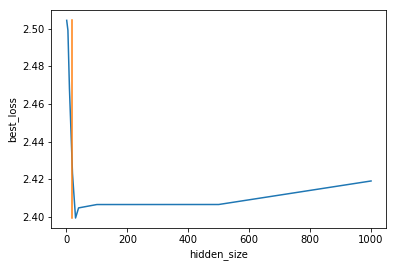

In [33]:


plt.plot(hidden_size_range, loss_list)
plt.plot((len(list(toy_graph.nodes)), len(list(toy_graph.nodes))), (min(loss_list), max(loss_list)))
plt.xlabel("hidden_size")
plt.ylabel("best_loss")

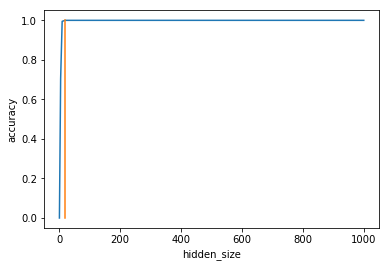

In [34]:
plt.plot(hidden_size_range, accuracy_list)
plt.plot((len(list(toy_graph.nodes)), len(list(toy_graph.nodes))), (min(accuracy_list), max(accuracy_list)))
plt.xlabel("hidden_size")
plt.ylabel("accuracy")

In [35]:
for i in range(len(hidden_size_range)):
    print(hidden_size_range[i], loss_list[i])

(1, 2.5043798925892475)
(5, 2.4990783294481673)
(10, 2.468235210839806)
(20, 2.4230122994925782)
(30, 2.3993636285199944)
(40, 2.404731579663017)
(100, 2.406522644829798)
(500, 2.406541764557454)
(1000, 2.4190411839026407)


# Does the LSTM output from a node depends on the node's position(time) ?

In [288]:
# works only on undirected graph
def construct_walk(node, time, graph):
    current_node = node
    walk = [current_node]
    for t in range(time):
        current_node = np.random.choice(list(nx.all_neighbors(graph, current_node)), 1)[0]
        walk.append(current_node)
    walk = walk[::-1]
    return walk
        

In [289]:
def study_time_inflence_on_node(graph, node, rnn):
    rnn.eval()
    time_range = [i for i in range(20)]
    nb_tries = 100
    time_results = np.zeros((len(time_range), nb_tries))
    hidden = rnn.initHidden()  
    for time in time_range:
        for trial in range(nb_tries):
            walk = construct_walk(node, time, graph)
            input_line_tensor = walk2input(walk, graph)
            rnn.initHidden()
            for i in range(input_line_tensor.size()[0]):
                output, hidden = rnn(input_line_tensor[i], hidden)
            topi = output.data.topk(1)[1][0][0]
            time_results[time][trial] = topi
    return time_results

#n_nodes = len(list(toy_graph.nodes))
#hidden_size = 50
#rnn = RNN(n_nodes + 2, hidden_size, n_nodes + 2)
#training_iters(4000, rnn, toy_graph, with_print=False))
# or use the pretrained rnn

In [290]:
time_results = study_time_inflence_on_node(toy_graph, 0, rnn)
nb_nodes = len(list(toy_graph.nodes))
time_results2 = np.zeros((time_results.shape[0], time_results.shape[1], nb_nodes + 2))
for i in range(time_results.shape[0]):
    for j in range(time_results.shape[1]):
        time_results2[i][j][int(time_results[i][j])] = 1

In [291]:
def dist(vect1, vect2):
    vect1 = np.array(vect1)
    vect2 = np.array(vect2)
    return np.dot((vect1 - vect2), (vect1 - vect2).T)

def intra_time_variance(m, t):
    mean_mat = np.mean(time_results2, axis = 1)
    return np.mean([dist(m[t][i], mean_mat[t]) for i in range(m.shape[1])])

def inter_time_variance(m, trial):
    mean_mat = np.mean(time_results2, axis = 0)
    return np.mean([dist(m[i][trial], mean_mat[trial]) for i in range(m.shape[0])])

In [292]:
print("Inter-time variance", np.mean([inter_time_variance(time_results2, i) for i in range(100)]))
print("Intra-time variance", np.mean([intra_time_variance(time_results2, i) for i in range(20)]))

('Inter-time variance', 0.65639999999999987)
('Intra-time variance', 0.27012999999999998)


distribution of output from node 2 given node 2 position in sequence


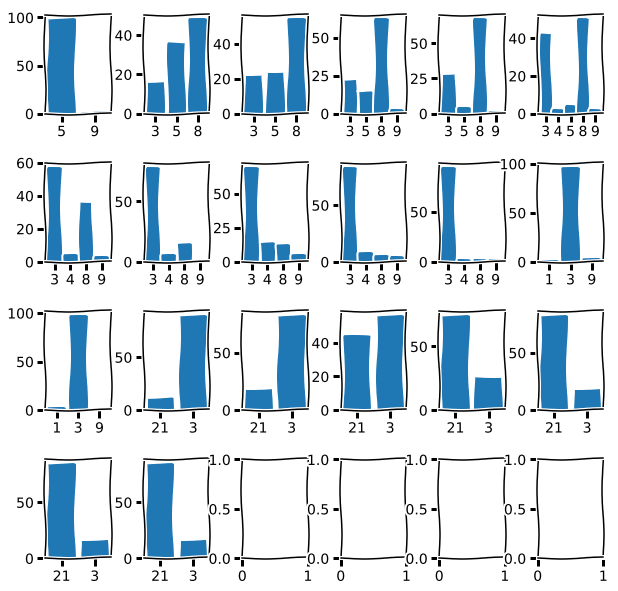

In [293]:
def distribution_through_time(graph, rnn, node, time_range):
    time_results = study_time_inflence_on_node(graph, node, rnn)
    fig, axes = plt.subplots(4, (len(time_range) / 3), figsize=(10, 10))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    print("distribution of output from node {} given node {} position in sequence".format(node, node))
    axes = axes.flatten()
    for t in time_range:
        data = np.unique(time_results[t].astype(int).astype(str), return_counts=True)
        pos = [i for i in range(len(data[0]))]
        axes[t].bar(pos, data[1])
        plt.sca(axes[t])
        plt.xticks(pos, data[0])
    
distribution_through_time(toy_graph, rnn, 2, [i for i in range(20)])

# Tools for visualizing neurons and LSTM memory

In [25]:
def list_weight_by_layer(rnn):

    i = 0
    weight_ih_l = list()
    weight_hh_l = list()
    bias_ih_l = list()
    bias_hh_l = list()
    while True:
        try:
                weight_ih_l.append(eval("rnn.lstm.weight_ih_l" + str(i)))
                weight_hh_l.append(eval("rnn.lstm.weight_hh_l" + str(i)))
                bias_ih_l.append(eval("rnn.lstm.bias_ih_l" + str(i)))
                bias_hh_l.append(eval("rnn.lstm.bias_hh_l" + str(i)))
        except:
            break
        i += 1
    
    return weight_ih_l, weight_hh_l, bias_ih_l, bias_hh_l
def visualize(rnn, input_tensor, neurons):
    gate_dict = {"input":0, "forget":1, "output":3}
    hidden = rnn.initHidden()
    rnn.eval()
    activation_list = [[] for i in range(len(neurons))]
    cell_state_list = list()
    output_list = list()
    start = time.time()
    list_paramaters = list_weight_by_layer(rnn)
    for i in range(input_tensor.size()[0]):
        former_hidden = hidden
        output, hidden = rnn(input_tensor[i], hidden)
        cell_state_list.append(hidden[1])
        output_list.append(hidden[0])
        for j, neuron in enumerate(neurons):
            gate = gate_dict[neuron["gate"]]
            layer = neuron["layer"]
            index = neuron["index"]

            # W_igate contains 4 concatained matrix Wii, Wfi, Wgi, Woi ! Same for other weight and bias
            W_igate = list_paramaters[0][layer]

            W_hgate = list_paramaters[1][layer]

            b_igate = list_paramaters[2][layer]

            b_hgate = list_paramaters[3][layer]


            if layer == 0:
                input_part = torch.mm(W_igate, input_tensor[i].view(-1, 1)) + b_igate
            else:
                input_part = torch.mm(W_igate, Variable(former_hidden[0][layer - 1].data.view(-1, 1)))
            hidden_part = Variable(torch.from_numpy(np.dot(W_hgate.data.numpy(), former_hidden[0][layer].data.view(-1, 1).numpy())))
            activation = F.sigmoid(input_part + hidden_part)[gate * rnn.hidden_size + index]
            
            activation_list[j].append(activation.data.numpy()[0])
    return input_tensor, activation_list, cell_state_list, output_list
            
    


In [44]:
def show_cell_activation_by_clique(sequence, cliques_list, linking_node_list, activation_list1, second_list=False, activation_list2=None, with_text=False, figsize=(7, 7)):
    plt.figure(figsize=figsize)
    color_list = ["red", (0.5, 0.5, 1), (0, 0.8, 0), "goldenrod", "pink", "purple"]
    for i, elem in enumerate(sequence):
        edge_color = "black" if elem in linking_node_list else None
        size = 80 if elem in linking_node_list else 60
        activation = activation_list1[i]
        color = "yellow"
        for j, clique in enumerate(cliques_list):
            if elem in clique:
                color = color_list[j]
        if not second_list:
            plt.scatter([activation], [i], c=color, edgecolors=edge_color, s=size)
        else:
            activation2 = activation_list2[i]
            plt.scatter([activation], [activation2], c=color, edgecolors=edge_color, s=size)
            if with_text:
                plt.text(activation, activation2, str(elem), fontsize=10)

# Testing the low-memory networks 

In [342]:
rnn.eval()

RNN (
  (lstm): LSTM(22, 5)
  (lin): Linear (5 -> 22)
  (softmax): LogSoftmax ()
)

In [42]:
hidden_size = 1
n_nodes = len(list(toy_graph.nodes))
print(n_nodes)
rnn_low_memory = RNN(n_nodes + 2, hidden_size, n_nodes + 2)

20
(22, 1)


In [43]:
all_losses = training_iters(4000, rnn_low_memory, functools.partial(train_vecs, graph=toy_graph), nn.NLLLoss(), optimizer_name="Adadelta")

0m 8s (100 2%) 3.2238
0m 17s (200 5%) 3.1611
0m 26s (300 7%) 3.1046
0m 37s (400 10%) 3.0833
0m 46s (500 12%) 3.0558
0m 55s (600 15%) 3.0180
1m 4s (700 17%) 2.9765
1m 13s (800 20%) 2.9187
1m 23s (900 22%) 2.8127
1m 31s (1000 25%) 2.7356
1m 38s (1100 27%) 2.6915
1m 47s (1200 30%) 2.6577
1m 56s (1300 32%) 2.6225
2m 8s (1400 35%) 2.6044
2m 16s (1500 37%) 2.5802
2m 27s (1600 40%) 2.5749
2m 37s (1700 42%) 2.5655
2m 46s (1800 45%) 2.5490
2m 54s (1900 47%) 2.5530
3m 2s (2000 50%) 2.5521
3m 9s (2100 52%) 2.5303
3m 16s (2200 55%) 2.5376
3m 23s (2300 57%) 2.5373
3m 30s (2400 60%) 2.5432
3m 38s (2500 62%) 2.5340
3m 47s (2600 65%) 2.5364
3m 56s (2700 67%) 2.5159
4m 4s (2800 70%) 2.5108
4m 13s (2900 72%) 2.5341
4m 20s (3000 75%) 2.5289
4m 27s (3100 77%) 2.5309
4m 34s (3200 80%) 2.5447
4m 42s (3300 82%) 2.5164
4m 49s (3400 85%) 2.5278
4m 57s (3500 87%) 2.5280
5m 6s (3600 90%) 2.5149
5m 15s (3700 92%) 2.5339
5m 24s (3800 95%) 2.5141
5m 33s (3900 97%) 2.5119
5m 41s (4000 100%) 2.5240


In [44]:
print(sample(toy_graph, rnn_low_memory, start=["6"]))

['6', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


In [43]:
neurons = []
walk = [i for i in range(20)]
activation_list_low_memory, cell_state_list_low_memory, output_list_low_memory = visualize(rnn_low_memory, walk2input(walk, toy_graph), neurons)[1:]
cell_state_list_low_memory = map(lambda x:x.data.numpy()[0][0][0], cell_state_list_low_memory)[1:]
output_list_low_memory = map(lambda x:x.data.numpy()[0][0], output_list_low_memory)[1:]
print(len(output_list_low_memory), len(cell_state_list_low_memory))

NameError: name 'rnn_low_memory' is not defined

IndexError: list index out of range

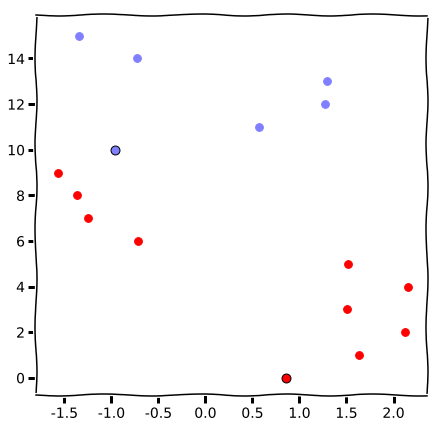

In [441]:
show_cell_activation_by_clique(walk, [[i for i in range(10)], [i for i in range(10, 20)]],[0, 10], cell_state_list_low_memory)

In [47]:
import matplotlib

In [50]:
matplotlib.font_manager.get_cachedir()

u'/root/.cache/matplotlib'

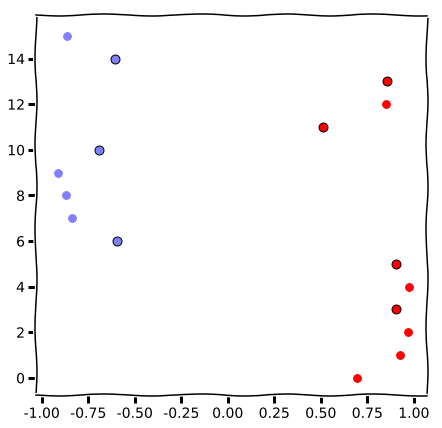

In [326]:
show_cell_activation_by_clique(walk, [[i for i in range(10)], [i for i in range(10, 20)]],[0, 10], output_list_low_memory)

## For bigger graphs ?

In [67]:
graph_3_cliques = cliques(3, 10)
graph_4_cliques = cliques(4, 10)

In [68]:
#nx.write_graphml(graph_4_cliques, "graph_4_cliques.graphml")

In [69]:
print(nx.info(graph_3_cliques))

Name: 
Type: Graph
Number of nodes: 30
Number of edges: 138
Average degree:   9.2000


In [70]:
hidden_size = 2
nb_nodes = len(list(graph_3_cliques))
rnn_3_cliques = RNN(nb_nodes + 2, hidden_size, nb_nodes + 2)


(32, 2)


In [71]:
hidden_size = 2
nb_nodes = len(list(graph_4_cliques))
rnn_4_cliques = RNN(nb_nodes + 2, hidden_size, nb_nodes + 2)

(42, 2)


In [72]:
criterion = nn.NLLLoss()

In [73]:
all_losses_4_cliques = training_iters(4000, rnn_4_cliques, functools.partial(train_vecs, graph=graph_4_cliques), criterion, optimizer_name="Adadelta")

0m 9s (100 2%) 3.8151
0m 20s (200 5%) 3.7588
0m 32s (300 7%) 3.6952
0m 39s (400 10%) 3.6185
0m 47s (500 12%) 3.5134
0m 55s (600 15%) 3.4967
1m 3s (700 17%) 3.4838
1m 11s (800 20%) 3.4011
1m 18s (900 22%) 3.4243
1m 27s (1000 25%) 3.3941
1m 35s (1100 27%) 3.4001
1m 43s (1200 30%) 3.2674
1m 50s (1300 32%) 3.2381
2m 0s (1400 35%) 3.2032
2m 8s (1500 37%) 3.1962
2m 17s (1600 40%) 3.1073
2m 25s (1700 42%) 3.1262
2m 34s (1800 45%) 3.0904
2m 42s (1900 47%) 3.0893
2m 50s (2000 50%) 3.0098
2m 59s (2100 52%) 2.9978
3m 10s (2200 55%) 2.9719
3m 21s (2300 57%) 2.9397
3m 31s (2400 60%) 2.9447
3m 41s (2500 62%) 2.8458
3m 49s (2600 65%) 2.8399
3m 59s (2700 67%) 2.8507
4m 7s (2800 70%) 2.8118
4m 14s (2900 72%) 2.8200
4m 21s (3000 75%) 2.7876
4m 29s (3100 77%) 2.8184
4m 36s (3200 80%) 2.7480
4m 43s (3300 82%) 2.7637
4m 51s (3400 85%) 2.8113
5m 1s (3500 87%) 2.7707
5m 9s (3600 90%) 2.8104
5m 17s (3700 92%) 2.7341
5m 26s (3800 95%) 2.7362
5m 35s (3900 97%) 2.7383
5m 43s (4000 100%) 2.7208


In [74]:
all_losses_3_cliques = training_iters(4000, rnn_3_cliques, functools.partial(train_vecs, graph=graph_3_cliques), criterion, optimizer_name="Adadelta")

0m 7s (100 2%) 3.5037
0m 15s (200 5%) 3.4816
0m 25s (300 7%) 3.4623
0m 31s (400 10%) 3.4365
0m 39s (500 12%) 3.3910
0m 46s (600 15%) 3.2919
0m 53s (700 17%) 3.2115
1m 0s (800 20%) 3.1759
1m 8s (900 22%) 3.0779
1m 19s (1000 25%) 3.0194
1m 27s (1100 27%) 3.0093
1m 36s (1200 30%) 2.9503
1m 44s (1300 32%) 2.8771
1m 53s (1400 35%) 2.8694
2m 1s (1500 37%) 2.8447
2m 9s (1600 40%) 2.8343
2m 17s (1700 42%) 2.7808
2m 58s (1800 45%) 2.7606
3m 6s (1900 47%) 2.7645
3m 13s (2000 50%) 2.7583
3m 20s (2100 52%) 2.7393
3m 27s (2200 55%) 2.7272
3m 34s (2300 57%) 2.6823
3m 41s (2400 60%) 2.6843
3m 48s (2500 62%) 2.7152
3m 56s (2600 65%) 2.6852
4m 3s (2700 67%) 2.6422
4m 11s (2800 70%) 2.6870
4m 18s (2900 72%) 2.6346
4m 25s (3000 75%) 2.6471
4m 32s (3100 77%) 2.6591
4m 39s (3200 80%) 2.6779
4m 47s (3300 82%) 2.6280
4m 54s (3400 85%) 2.6316
5m 1s (3500 87%) 2.6381
5m 9s (3600 90%) 2.6288
5m 16s (3700 92%) 2.6307
5m 23s (3800 95%) 2.6277
5m 31s (3900 97%) 2.6251
5m 38s (4000 100%) 2.6221


In [75]:
def cliques_list_func(nb_cliques, clique_size):
    cliques_list = [[i for i in range(a * clique_size, (a + 1) *  clique_size)] for a in range(nb_cliques)]
    return cliques_list

In [76]:
neurons = []
walk = [i for i in range(40)]
activation_list_4_cliques, cell_state_list_4_cliques, output_list_4_cliques = visualize(rnn_4_cliques, walk2input(walk, graph_4_cliques), neurons)[1:]
#print(len(walk), len(cell_state_list[1:]))

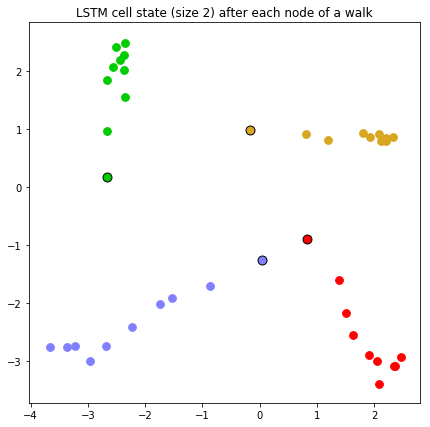

In [77]:
cell_state_list2 = np.array(map(lambda x:x.data.numpy(), cell_state_list_4_cliques)).reshape(-1, 2)
memory1 = cell_state_list2[:, 0][1:]
memory2 = cell_state_list2[:, 1][1:]

show_cell_activation_by_clique(walk, cliques_list_func(4, 10), [10*i for i in range(4)], memory1, True, memory2)
plt.title("LSTM cell state (size 2) after each node of a walk")

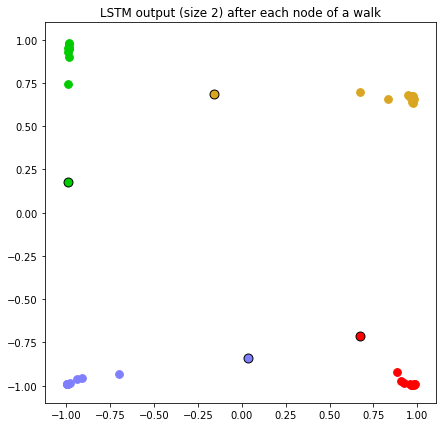

In [78]:
output_list_4_cliques2 = np.array(map(lambda x:x.data.numpy(), output_list_4_cliques)).reshape(-1, 2)
memory1 = output_list_4_cliques2[:, 0][1:]
memory2 = output_list_4_cliques2[:, 1][1:]

show_cell_activation_by_clique(walk, cliques_list_func(4, 10), [10*i for i in range(4)], memory1, True, memory2)
plt.title("LSTM output (size 2) after each node of a walk")

In [79]:
neurons = []
walk = [i for i in range(30)]
activation_list_3_cliques, cell_state_list_3_cliques, output_list_3_cliques = visualize(rnn_3_cliques, walk2input(walk, graph_3_cliques), neurons)[1:]
#print(len(walk), len(cell_state_list[1:]))

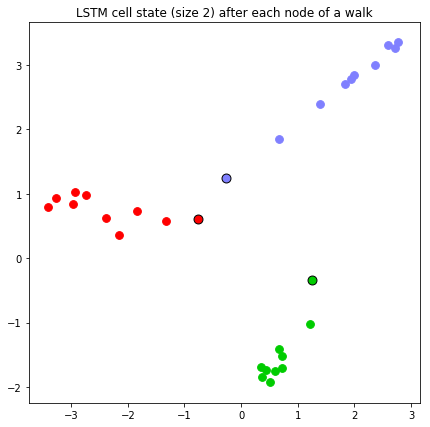

In [80]:
cell_state_list2 = np.array(map(lambda x:x.data.numpy(), cell_state_list_3_cliques)).reshape(-1, 2)
memory1 = cell_state_list2[:, 0][1:]
memory2 = cell_state_list2[:, 1][1:]

show_cell_activation_by_clique(walk, cliques_list_func(3, 10), [10*i for i in range(3)], memory1, True, memory2)
plt.title("LSTM cell state (size 2) after each node of a walk")

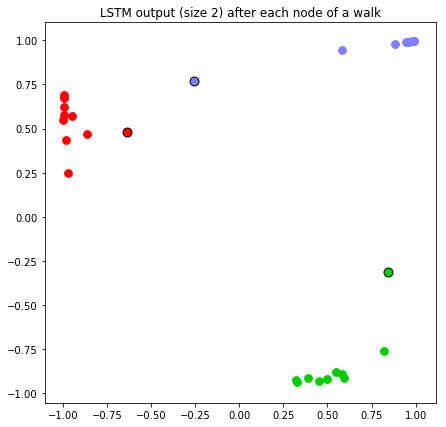

In [81]:
output_list_3_cliques2 = np.array(map(lambda x:x.data.numpy(), output_list_3_cliques)).reshape(-1, 2)
memory1 = output_list_3_cliques2[:, 0][1:]
memory2 = output_list_3_cliques2[:, 1][1:]

show_cell_activation_by_clique(walk, cliques_list_func(4, 10), [10*i for i in range(4)], memory1, True, memory2)
plt.title("LSTM output (size 2) after each node of a walk")

In [89]:
n_nodes_toy_graph = len(list(toy_graph.nodes))
hidden_size_rnn_toy_graph = 80
rnn_toy_graph = RNN(n_nodes_toy_graph + 2, hidden_size_rnn_toy_graph, n_nodes_toy_graph + 2)
criterion = nn.NLLLoss()
all_losses_toy_graph = training_iters(5000, rnn_toy_graph, functools.partial(train_vecs, graph=toy_graph), criterion, optimizer_name="Adadelta")

(42, 80)
0m 58s (100 2%) 3.5773
1m 38s (200 4%) 3.0811
1m 46s (300 6%) 2.9629
1m 54s (400 8%) 2.8581
2m 2s (500 10%) 2.6973
2m 12s (600 12%) 2.7461
2m 20s (700 14%) 2.6696
2m 28s (800 16%) 2.6454
2m 39s (900 18%) 2.6298
2m 47s (1000 20%) 2.6391
2m 57s (1100 22%) 2.6161
3m 7s (1200 24%) 2.5984
3m 15s (1300 26%) 2.6332
3m 23s (1400 28%) 2.5959
3m 33s (1500 30%) 2.6092
3m 43s (1600 32%) 2.5650
3m 53s (1700 34%) 2.5690
4m 1s (1800 36%) 2.5763
4m 11s (1900 38%) 2.5517
4m 21s (2000 40%) 2.5388
4m 30s (2100 42%) 2.5478
4m 40s (2200 44%) 2.5300
4m 49s (2300 46%) 2.5418
4m 57s (2400 48%) 2.5469
5m 9s (2500 50%) 2.5319
5m 18s (2600 52%) 2.5445
5m 30s (2700 54%) 2.5401
5m 43s (2800 56%) 2.5532
5m 52s (2900 57%) 2.5500
6m 5s (3000 60%) 2.5286
6m 14s (3100 62%) 2.5235
6m 27s (3200 64%) 2.5288
6m 35s (3300 66%) 2.5324
6m 46s (3400 68%) 2.5306
6m 54s (3500 70%) 2.5328
7m 2s (3600 72%) 2.5258
7m 10s (3700 74%) 2.5463
7m 22s (3800 76%) 2.5259
7m 29s (3900 78%) 2.5409
7m 37s (4000 80%) 2.5332
7m 45s (41

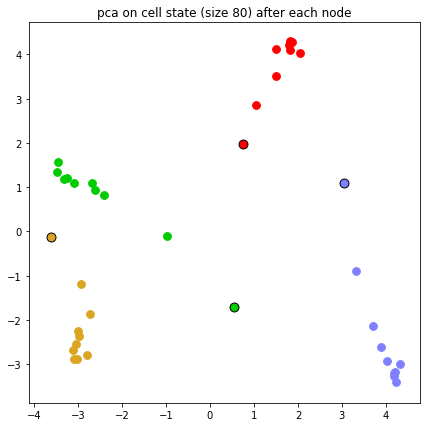

In [90]:
neurons = []
walk = [i for i in range(40)]
activation_list_high_memory, cell_state_list_high_memory, output_list_high_memory = visualize(rnn_toy_graph, walk2input(walk, toy_graph), neurons)[1:]
pca = decomposition.PCA(n_components=2)
cell_state_list_high_memory = map(lambda x:x.data.numpy().flatten(), cell_state_list_high_memory)[1:]
cell_state_list_high_memory = np.array(cell_state_list_high_memory).reshape(len(walk), rnn_toy_graph.hidden_size)
output_list_high_memory = map(lambda x:x.data.numpy().flatten(), output_list_high_memory)[1:]
output_list_high_memory = np.array(output_list_high_memory).reshape(len(walk), rnn_toy_graph.hidden_size)
reduced_cell_state_list_high_memory = pca.fit_transform(cell_state_list_high_memory)

memory1, memory2 = reduced_cell_state_list_high_memory[:, 0], reduced_cell_state_list_high_memory[:, 1]
show_cell_activation_by_clique(walk, cliques_list_func(4, 10), [10 * i for i in range(4)], memory1, True, memory2)
plt.title("pca on cell state (size {}) after each node".format(hidden_size_rnn_toy_graph))

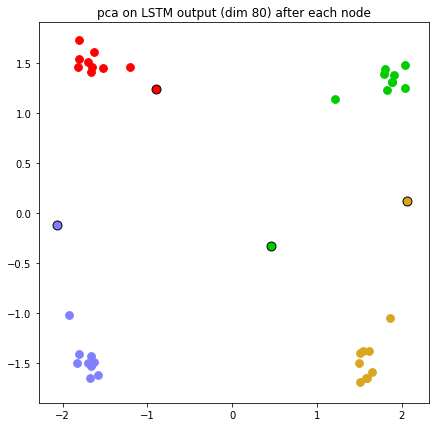

In [91]:
reduced_output_list_high_memory = pca.fit_transform(output_list_high_memory)
memory1, memory2 = reduced_output_list_high_memory[:, 0], reduced_output_list_high_memory[:, 1]
show_cell_activation_by_clique(walk, cliques_list_func(4, 10), [i * 10 for i in range(4)], memory1, True, memory2)
plt.title("pca on LSTM output (dim {}) after each node".format(hidden_size_rnn_toy_graph))

In [92]:
from sklearn import decomposition

[1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 0, 0, 4, 4, 4, 4, 0, 2, 5, 5, 5, 5, 5, 1, 1, 0, 0, 0, 4, 0, 0, 4, 4, 4, 0, 1, 0, 0, 0, 0, 0, 0, 4, 1, 0, 1, 1, 0, 0, 3, 0, 3, 3, 5, 5, 5, 5, 5, 1, 3, 1, 1, 0, 3, 3, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2]
[[26, 27, 28, 11, 10, 13, 15, 14, 54, 56, 51, 50, 53, 52, 55, 49, 44, 45, 43, 72, 39, 33, 32, 31, 30], [60, 61, 62, 63, 64, 65, 66, 67, 59, 58, 57, 48, 46, 47, 76, 74, 73], [29, 38, 37, 36, 35, 34], [68, 69, 24, 25, 42, 40, 41, 75, 71, 70], [20, 21, 22, 23, 12, 17, 16, 19, 18], [0, 2, 4, 6, 8, 1, 3, 5, 7, 9]]


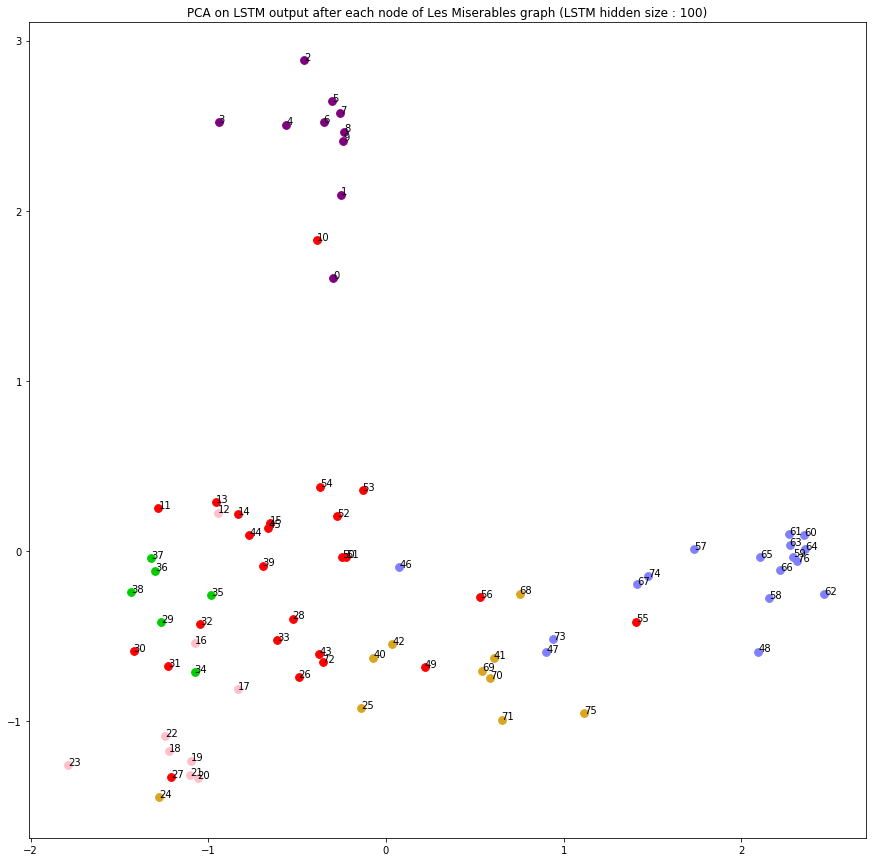

In [95]:
import community.community_louvain as ct
def embedd_graph(graph, rnn, show_output=True):
    nb_nodes = len(list(graph.nodes))
    walk= [i for i in range(nb_nodes)]
    neurons = []
    activation_list, cell_state_list, output_list = visualize(rnn, walk2input(walk, graph), neurons)[1:]
    pca = decomposition.PCA(n_components=2)
    cell_state_list = map(lambda x:x.data.numpy().flatten(), cell_state_list)[1:]
    cell_state_list = np.array(cell_state_list).reshape(len(walk), rnn.hidden_size)
    output_list = map(lambda x:x.data.numpy().flatten(), output_list)[1:]
    output_list = np.array(output_list).reshape(len(walk), rnn.hidden_size)
    if show_output:
        reduced_output_list = pca.fit_transform(output_list)
        res1, res2 = reduced_output_list[:, 0], reduced_output_list[:, 1]
    else:
        reduced_cell_state_list = pca.fit_transform(cell_state_list)
        res1, res2 = reduced_cell_state_list[:, 0], reduced_cell_state_list[:, 1]
    part = ct.best_partition(graph)
    print([value for value in part.values()])
    community_list = [[int(key) for key in part.keys() if part[key]==value] for value in np.unique(part.values())]
    print(community_list)
    plt.figure(figsize=(20, 20))
    show_cell_activation_by_clique(walk, community_list, [], res1, True, res2, with_text=True, figsize=(15, 15)) # trick to reuse function
    plt.title("PCA on LSTM output after each node of Les Miserables graph (LSTM hidden size : {})".format(rnn.hidden_size))

embedd_graph(graph, rnn)

# Saving the network 

import pickle

file = open('rnn_random_walk', "wb")

pickle.dump(rnn, file)